In [ ]:
import numpy as np
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer

import nncf

In [ ]:
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = OVModelForCausalLM.from_pretrained(MODEL_ID, export=True, load_in_8bit=False, compile=False)

In [3]:
ov_model_fp = model.model

In [5]:
from optimum.gptq.data import get_dataset
from optimum.gptq.data import prepare_dataset

dataset = "wikitext2"
seqlen = 50
nsamples = 2
calibration_dataset = get_dataset(dataset, tokenizer, seqlen=seqlen, nsamples=nsamples)
calibration_dataset = prepare_dataset(calibration_dataset)
quantization_dataset = nncf.Dataset(calibration_dataset, lambda x: model.prepare_inputs(**x))

In [6]:
from profiler import NNCFProfiler

profiler = NNCFProfiler(pattern = r'.*\.self_attn\.k_proj/ov_ext::linear/MatMul', 
                        dataset=quantization_dataset, 
                        num_samples=2)

In [ ]:
data_fp = profiler.collect_activations(ov_model_fp)

In [8]:
data_fp.keys()

dict_keys(['__module.model.layers.0.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.1.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.2.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.3.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.4.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.5.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.6.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.7.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.8.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.9.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.10.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.11.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.12.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.13.self_attn.k_proj/ov_ext::linear/MatMul', '__module.model.layers.14.self_attn.k_proj/ov_ext::linear/Mat

In [9]:
stats_fp = profiler.calculate_stats(data_fp, statistics=["min", "max", "mean"])
stats_fp.head()

,name,type,min,max,mean
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-2.423581,4.579813,0.000833
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-12.260908,5.716366,-0.089344
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-9.937587,3.186697,-0.002953
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-7.528746,9.461468,0.091903
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-8.955494,4.877494,-0.001711


In [10]:
# It's possible to register your own statistics

@NNCFProfiler.statistic("percentile_95")
def _stat_percentile_95(vals: np.ndarray) -> float:
    """Calculate the 95th percentile of activations."""
    return float(np.percentile(vals, 95))


stats_fp = profiler.calculate_stats(data_fp, statistics=["min", "max", "mean", "percentile_95"])
stats_fp.head()

,name,type,min,max,mean,percentile_95
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-2.423581,4.579813,0.000833,0.012635
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-12.260908,5.716366,-0.089344,1.667681
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-9.937587,3.186697,-0.002953,0.054085
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-7.528746,9.461468,0.091903,3.942587
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-8.955494,4.877494,-0.001711,0.107082


In [ ]:
from nncf import CompressWeightsMode
from nncf import compress_weights

ov_model_int8 = compress_weights(ov_model_fp, mode=CompressWeightsMode.INT8_SYM, ratio=1.0)

In [12]:
data_int8 = profiler.collect_activations(ov_model_int8)

In [13]:
comp_res = profiler.compare_activations(data_fp, 
                                        data_int8, 
                                        metrics=["mean_diff", "std_diff"], 
                                        statistics = ["min", "max", "mean"])
comp_res.head()

,name,type,min_data1,max_data1,mean_data1,min_data2,max_data2,mean_data2,mean_diff,std_diff
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-2.423581,4.579813,0.000833,-2.424530,4.578940,0.000829,0.000004,0.000662
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-12.260908,5.716366,-0.089344,-12.261600,5.720257,-0.089401,0.000056,0.00664
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-9.937587,3.186697,-0.002953,-9.938596,3.170657,-0.002951,-0.000002,0.001259
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-7.528746,9.461468,0.091903,-7.521993,9.442310,0.092248,-0.000345,0.010234
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-8.955494,4.877494,-0.001711,-8.954531,4.843205,-0.001716,0.000005,0.003615


In [14]:
# You can register your own function for comparing statistics

@NNCFProfiler.comparator("relative_diff")
def _relative_diff(a: np.ndarray, b: np.ndarray) -> float:
    """Calculate the mean relative difference between two activation arrays."""
    epsilon = 1e-8
    return float((np.abs(a - b) / (np.abs(a) + epsilon)).mean())

In [15]:
comp_res = profiler.compare_activations(data_fp, 
                                        data_int8, 
                                        metrics=["mean_diff", "std_diff", "relative_diff"], 
                                        statistics = ["min", "max", "mean"])
comp_res.head()

,name,type,min_data1,max_data1,mean_data1,min_data2,max_data2,mean_data2,mean_diff,std_diff,relative_diff
0,__module.model.layers.0.self_attn.k_proj/ov_ex...,in,-2.423581,4.579813,0.000833,-2.424530,4.578940,0.000829,0.000004,0.000662,0.0633
1,__module.model.layers.0.self_attn.k_proj/ov_ex...,out,-12.260908,5.716366,-0.089344,-12.261600,5.720257,-0.089401,0.000056,0.00664,0.060019
2,__module.model.layers.1.self_attn.k_proj/ov_ex...,in,-9.937587,3.186697,-0.002953,-9.938596,3.170657,-0.002951,-0.000002,0.001259,0.162017
3,__module.model.layers.1.self_attn.k_proj/ov_ex...,out,-7.528746,9.461468,0.091903,-7.521993,9.442310,0.092248,-0.000345,0.010234,0.024252
4,__module.model.layers.2.self_attn.k_proj/ov_ex...,in,-8.955494,4.877494,-0.001711,-8.954531,4.843205,-0.001716,0.000005,0.003615,0.356471


In [ ]:
# It's also possible to register your own visualizer (see the implemenation in nncf/tools/profiler.py)

# @NNCFProfiler.visualizer("compare_detailed")
# def _compare_detailed_plot(
#     data1: ActivationData,
#     data2: ActivationData,
#     activation_type: Optional[str] = None,
#     bins: int = 100,
#     show_histograms: bool = True,
#     show_summary: bool = True,
#     display_figures: bool = False,
#     data1_label: str = 'data1',
#     data2_label: str = 'data2',
#     **kwargs
# ): 

In [16]:
all_figs, summary_figs = profiler.plot("compare_detailed", 
                                       data_fp, 
                                       data_int8, 
                                       data1_label='data_fp', 
                                       data2_label = 'data_int8', 
                                       display_figures=False)

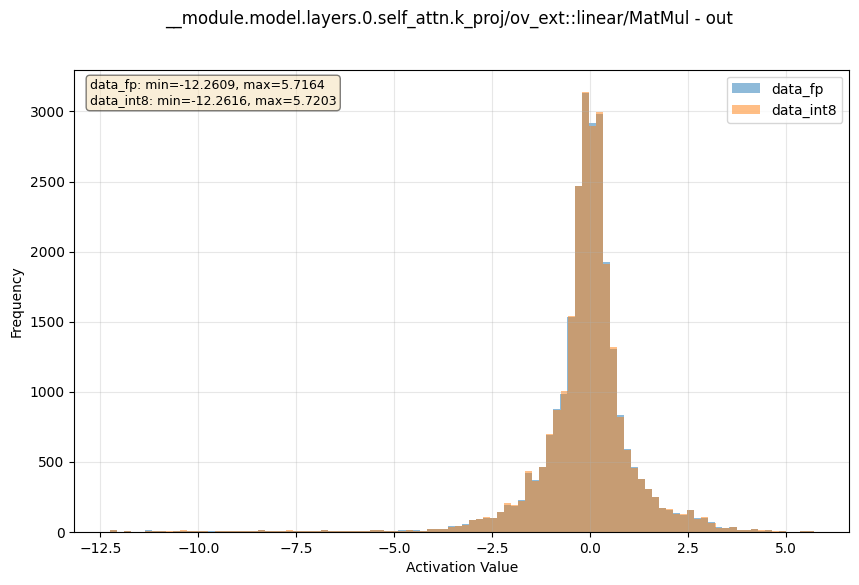

In [17]:
from IPython.display import display

display(all_figs['__module.model.layers.0.self_attn.k_proj/ov_ext::linear/MatMul']['out'])

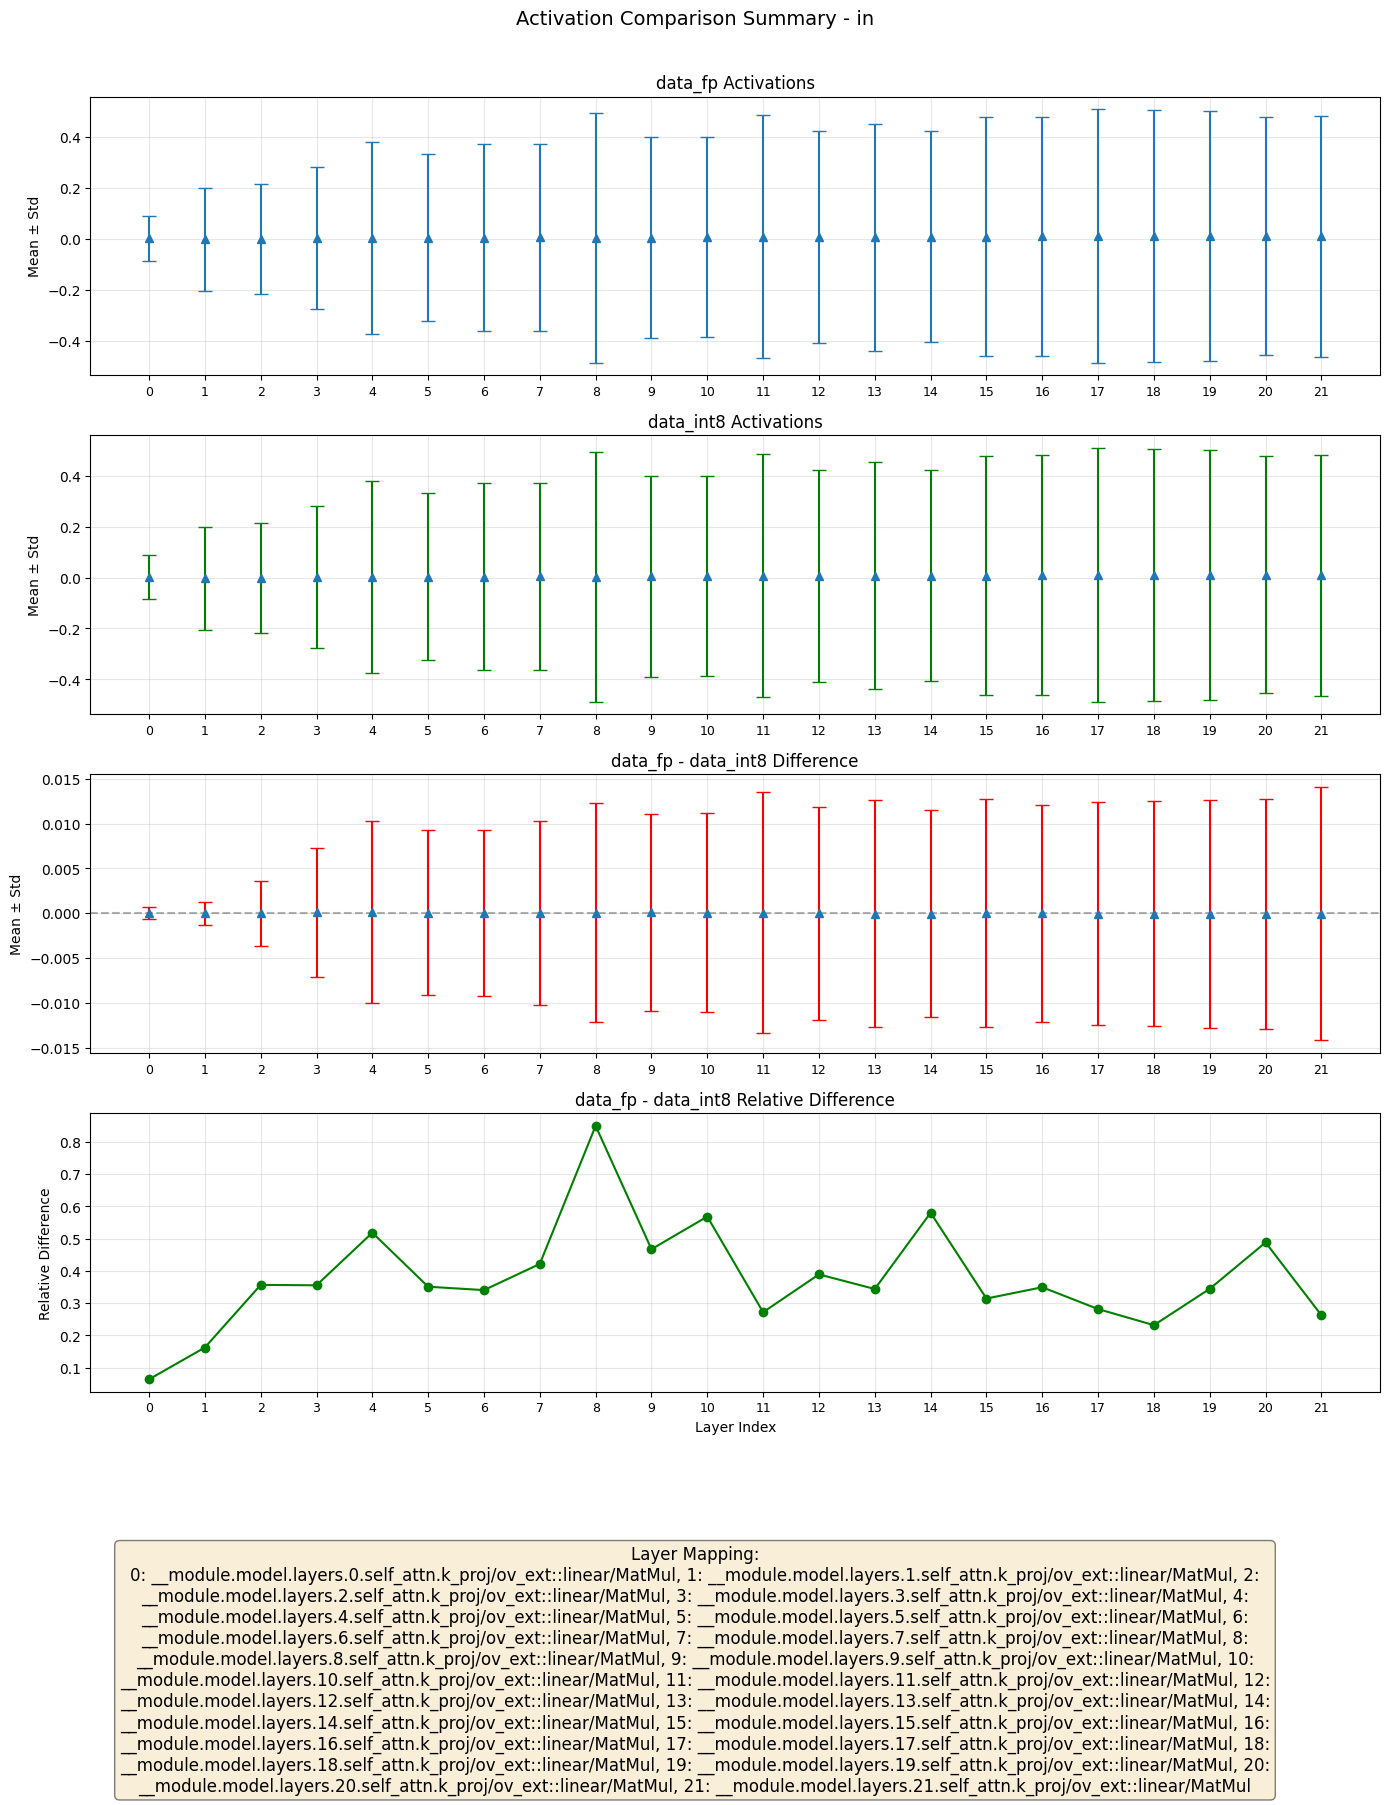

In [18]:
display(summary_figs['in'])